In [1]:
import pandas as pd
import numpy as np
from zipfile import ZipFile
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from pathlib import Path
import matplotlib.pyplot as plt

Loading the data and Preprocessing

In [3]:
movielens_data_file_url = (
    "http://files.grouplens.org/datasets/movielens/ml-latest-small.zip"
)

movielens_zipped_file = keras.utils.get_file(
    "ml-latest-small.zip", movielens_data_file_url, extract=False
)

keras_datasets_path = Path(movielens_zipped_file).parents[0]
movielens_dir = keras_datasets_path / "ml-latest-small"

if not movielens_dir.exists():
    with ZipFile(movielens_zipped_file, "r") as zip:
        print("Extracting all the files now...")
        zip.extractall(path=keras_datasets_path)
        print("Done!")

ratings_file = movielens_dir / "ratings.csv"
tags_file = movielens_dir / "tags.csv"
movies_file = movielens_dir / "movies.csv"

df = pd.read_csv(ratings_file)
tags = pd.read_csv(tags_file)
movies = pd.read_csv(movies_file)

978202/978202 [==============================] - 0s 0us/step
Extracting all the files now...
Done!


 Exploratory Data Analysis

In [4]:
df.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [5]:
df.shape

(100836, 4)

In [6]:
df.describe()


,userId,movieId,rating,timestamp
count,100836.000000,100836.000000,100836.000000,1.008360e+05
mean,326.127564,19435.295718,3.501557,1.205946e+09
std,182.618491,35530.987199,1.042529,2.162610e+08
min,1.000000,1.000000,0.500000,8.281246e+08
25%,177.000000,1199.000000,3.000000,1.019124e+09
50%,325.000000,2991.000000,3.500000,1.186087e+09
75%,477.000000,8122.000000,4.000000,1.435994e+09
max,610.000000,193609.000000,5.000000,1.537799e+09


In [7]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


HeatMap for better understanding of Features

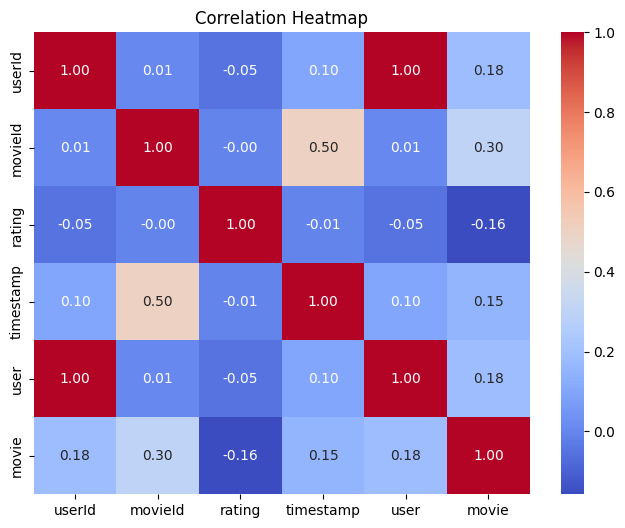

In [17]:
import seaborn as sns
corr = df.corr()

# Generate a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

PairPlot to visualize the data

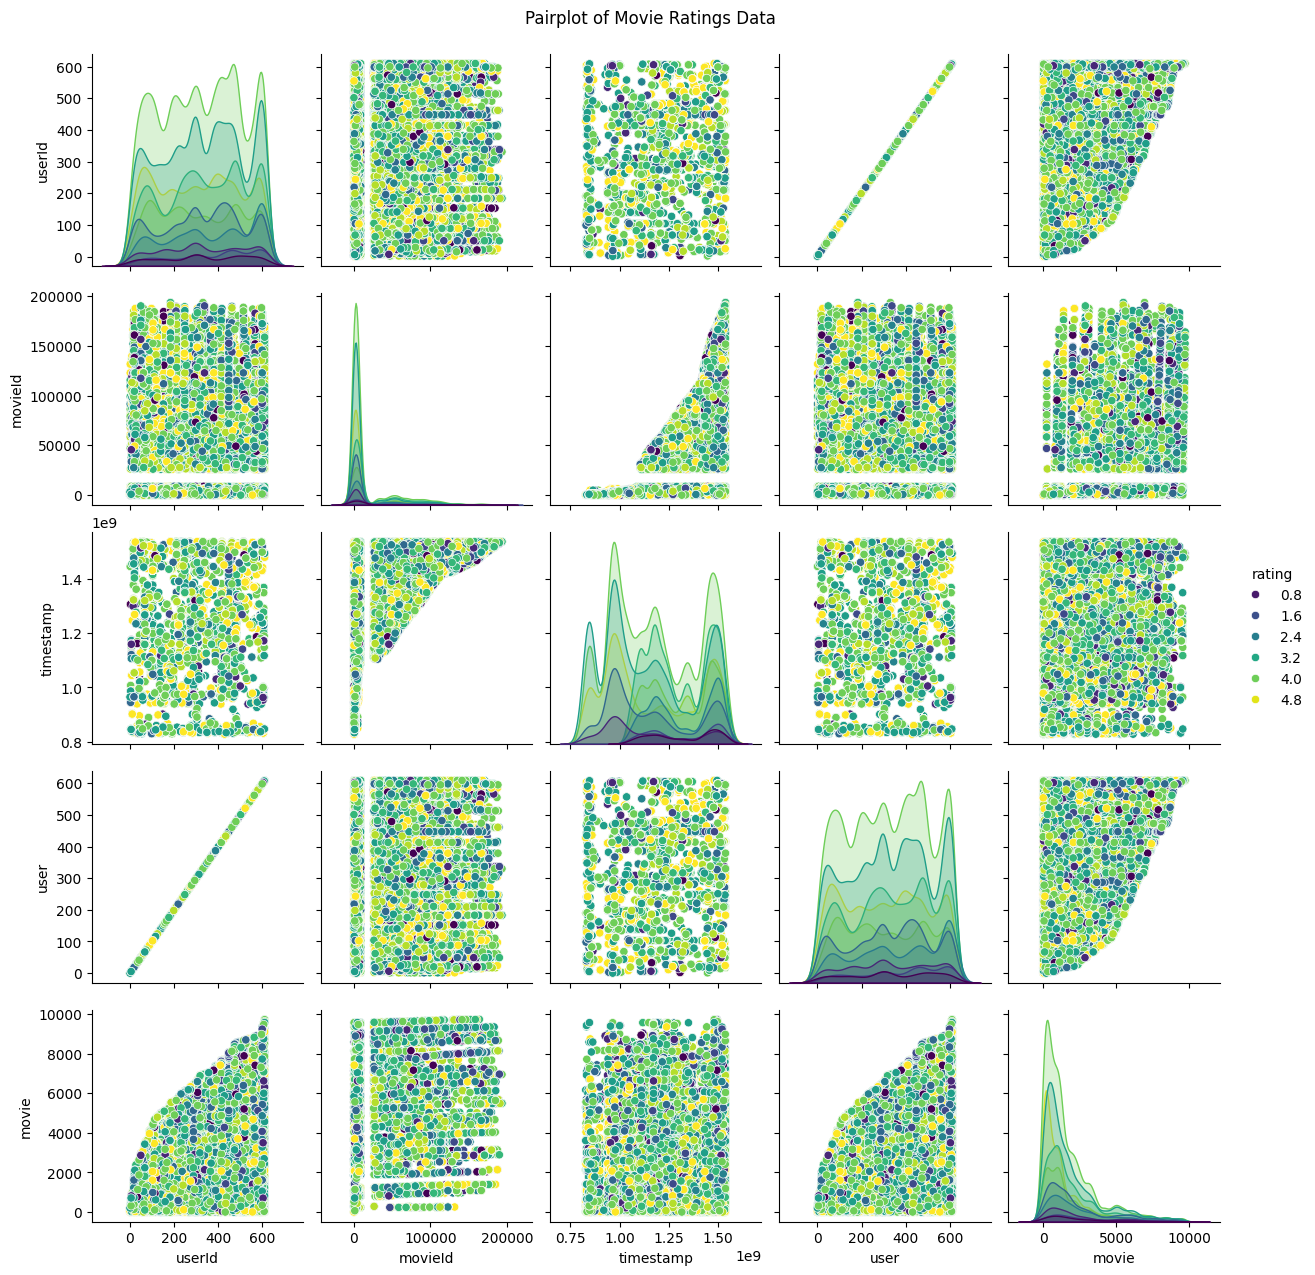

In [33]:
# Generate a pairplot
sns.pairplot(df, hue='rating', palette='viridis')
plt.suptitle('Pairplot of Movie Ratings Data', y=1.02)
plt.show()

In [8]:
user_ids = df["userId"].unique().tolist()
user2user_encoded = {x: i for i, x in enumerate(user_ids)}
userencoded2user = {i: x for i, x in enumerate(user_ids)}

movie_ids = df["movieId"].unique().tolist()
movie2movie_encoded = {x: i for i, x in enumerate(movie_ids)}
movie_encoded2movie = {i: x for i, x in enumerate(movie_ids)}

df["user"] = df["userId"].map(user2user_encoded)
df["movie"] = df["movieId"].map(movie2movie_encoded)

num_users = len(user2user_encoded)
num_movies = len(movie_encoded2movie)
df['rating'] = df['rating'].values.astype(np.float32)
#Normalization
min_rating = min(df["rating"])
max_rating = max(df["rating"])

print(f"Number of users: {num_users}, Number of Movies: {num_movies}, Min Rating: {min_rating}, Max Rating: {max_rating}")

Number of users: 610, Number of Movies: 9724, Min Rating: 0.5, Max Rating: 5.0


Preparing the Data


In [9]:
df = df.sample(frac=1, random_state=42)
x = df[["user", "movie"]].values

# Normalizing the targets between 0 and 1.
y = df["rating"].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values

# Assuming training on 90% of the data and validating on 100%
train_indices = int(0.9 * df.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:],
)

Creation of a Model

Training the Model

In [13]:
EMBEDDING_SIZE = 50

class RecommenderNet(keras.Model):
    def __init__(self, num_users, num_movies, embedding_size, **kwargs):
        super(RecommenderNet, self).__init__(**kwargs)
        self.num_users = num_users
        self.num_movies = num_movies
        self.embedding_size = embedding_size
        self.user_embedding = layers.Embedding(
            num_users,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.user_bias = layers.Embedding(num_users, 1)
        self.movie_embedding = layers.Embedding(
            num_movies,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6)
        )
        self.movie_bias = layers.Embedding(num_movies, 1)

    def call(self, inputs):
        user_vector = self.user_embedding(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
        movie_vector = self.movie_embedding(inputs[:, 1])
        movie_bias = self.movie_bias(inputs[:, 1])
        dot_user_movie = tf.tensordot(user_vector, movie_vector, 2)
        # Add all the components (including bias)
        x = dot_user_movie + user_bias + movie_bias
        # The sigmoid activation forces the rating to be between 0 and 11
        return tf.nn.sigmoid(x)

model = RecommenderNet(num_users, num_movies, EMBEDDING_SIZE)
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(), optimizer=keras.optimizers.Adam(lr=0.001)
)

In [14]:
history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=64,
    epochs=5,
#     verbose=1,
    validation_data=(x_val, y_val)
)

Epoch 1/5
1418/1418 [==============================] - 15s 10ms/step - loss: 0.6360 - val_loss: 0.6202
Epoch 2/5
1418/1418 [==============================] - 13s 9ms/step - loss: 0.6135 - val_loss: 0.6169
Epoch 3/5
1418/1418 [==============================] - 13s 9ms/step - loss: 0.6088 - val_loss: 0.6135
Epoch 4/5
1418/1418 [==============================] - 13s 9ms/step - loss: 0.6071 - val_loss: 0.6123
Epoch 5/5
1418/1418 [==============================] - 12s 9ms/step - loss: 0.6062 - val_loss: 0.6123


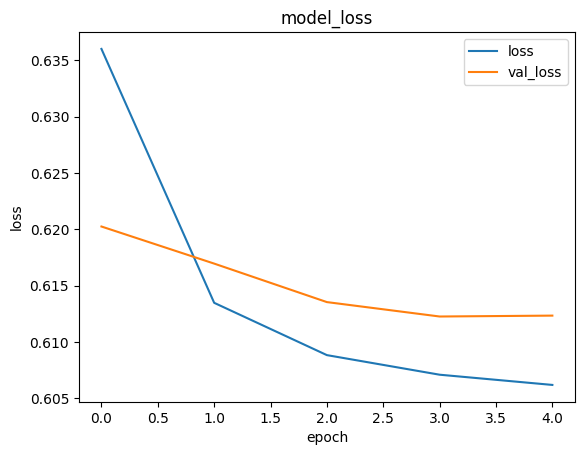

In [15]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('model_loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()

Show top 10 movie recommendations to a
user

In [19]:
movie_df = pd.read_csv(movielens_dir / 'movies.csv')

user_id = df.userId.sample(1).iloc[0]
movies_watched_by_user = df[df.userId == user_id]
movies_not_watched = movie_df[~movie_df['movieId'].isin(movies_watched_by_user.movieId.values)]['movieId']

movies_not_watched = list(set(movies_not_watched).intersection(set(movie2movie_encoded.keys())))

movies_not_watched = [[movie2movie_encoded.get(x)] for x in movies_not_watched]

user_encoder = user2user_encoded.get(user_id)

user_movie_array = np.hstack(
    ([[user_encoder]] * len(movies_not_watched), movies_not_watched)
)

ratings = model.predict(user_movie_array).flatten()
top_ratings_indices = ratings.argsort()[-10:][::-1]
recommended_movie_ids = [
    movie_encoded2movie.get(movies_not_watched[x][0]) for x in top_ratings_indices
]

289/289 [==============================] - 0s 1ms/step


In [21]:
print("Showing recommendations for user: {}".format(user_id))
print("====" * 9)
print("Movies with high ratings from user")
print("----" * 8)
top_movies_user = (
    movies_watched_by_user.sort_values(by="rating", ascending=False)
    .head(5)
    .movieId.values
)
movie_df_rows = movie_df[movie_df["movieId"].isin(top_movies_user)]
for row in movie_df_rows.itertuples():
    print(row.title, ":", row.genres)

print("----" * 8)
print("Top 10 movie recommendations")
print("----" * 8)
recommended_movies = movie_df[movie_df["movieId"].isin(recommended_movie_ids)]
for row in recommended_movies.itertuples():
    print(row.title, ":", row.genres)

Showing recommendations for user: 525
Movies with high ratings from user
--------------------------------
Virgin Suicides, The (1999) : Drama|Romance
Ocean's Eleven (2001) : Crime|Thriller
Love Actually (2003) : Comedy|Drama|Romance
Moonrise Kingdom (2012) : Comedy|Drama|Romance
Kingsman: The Secret Service (2015) : Action|Adventure|Comedy|Crime
--------------------------------
Top 10 movie recommendations
--------------------------------
Good, the Bad and the Ugly, The (Buono, il brutto, il cattivo, Il) (1966) : Action|Adventure|Western
12 Angry Men (1957) : Drama
Lawrence of Arabia (1962) : Adventure|Drama|War
Apocalypse Now (1979) : Action|Drama|War
Third Man, The (1949) : Film-Noir|Mystery|Thriller
Goodfellas (1990) : Crime|Drama
Godfather: Part II, The (1974) : Crime|Drama
Amadeus (1984) : Drama
Boot, Das (Boat, The) (1981) : Action|Drama|War
Chinatown (1974) : Crime|Film-Noir|Mystery|Thriller


Recommenders

In [22]:
!/opt/conda/bin/python3.7 -m pip install --upgrade pip


/bin/bash: line 1: /opt/conda/bin/python3.7: No such file or directory


In [23]:
!pip install -q tensorflow-recommenders
!pip install -q --upgrade tensorflow-datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.2/96.2 kB 1.5 MB/s eta 0:00:00


In [32]:
# Load data on movie ratings.
ratings = tfds.load("movielens/100k-ratings", split="train")
movies = tfds.load("movielens/100k-movies", split="train")

# Prepare the ratings dataset
ratings = ratings.map(lambda x: {
    "movie_id": tf.strings.as_string(x["movie_id"]),
    "user_id": tf.strings.as_string(x["user_id"])
})

# Prepare the movies dataset
movies = movies.map(lambda x: tf.strings.as_string(x["movie_id"]))

# Build flexible representation models.
user_model = tf.keras.Sequential([
    layers.StringLookup(vocabulary=tf.constant([str(i) for i in range(1000)])),
    layers.Embedding(input_dim=1000, output_dim=32)
])

movie_model = tf.keras.Sequential([
    layers.StringLookup(vocabulary=tf.constant([str(i) for i in range(1000)])),
    layers.Embedding(input_dim=1000, output_dim=32)
])

# Define a retrieval model
class MovielensModel(tfrs.Model):

    def __init__(self, user_model, movie_model, task):
        super().__init__()
        self.movie_model: tf.keras.Model = movie_model
        self.user_model: tf.keras.Model = user_model
        self.task: tf.keras.layers.Layer = task

    def compute_loss(self, features: Dict[str, tf.Tensor], training=False) -> tf.Tensor:
        # We pick out the user features and pass them into the user model.
        user_embeddings = self.user_model(features["user_id"])
        # And pick out the movie features and pass them into the movie model,
        # getting embeddings back.
        positive_movie_embeddings = self.movie_model(features["movie_id"])

        # The task computes the loss and the metrics.
        return self.task(user_embeddings, positive_movie_embeddings)

# Define your objectives.
task = tfrs.tasks.Retrieval(metrics=tfrs.metrics.FactorizedTopK(
    movies.batch(128).map(lambda x: (x, movie_model(x)))
))

# Create a retrieval model.
model = MovielensModel(user_model, movie_model, task)
model.compile(optimizer=tf.keras.optimizers.Adagrad(0.5))

try:
    # Train.
    model.fit(ratings.batch(4096), epochs=3)
except Exception as e:
    print("Error during training:", e)

# Set up retrieval using trained representations.
try:
    index = tfrs.layers.ann.BruteForce(model.user_model)
    index.index(movies.batch(100).map(lambda x: (x, movie_model(x))), movies)
except Exception as e:
    print("Error setting up retrieval:", e)

# Get recommendations.
try:
    user_id = tf.constant(["42"])
    _, titles = index(user_id)
    print(f"Recommendations for user 42: {titles[0, :3]}")
except Exception as e:
    print("Error getting recommendations:", e)


Epoch 1/3
Error during training: Graph execution error:

Detected at node sequential_14/embedding_21/embedding_lookup defined at (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code

  File "/usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py", line 37, in <module>

  File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelapp.py", line 619, in start

  File "/usr/local/lib/python3.10/dist-packages/tornado/platform/asyncio.py", line 195, in start

  File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 685, in <lambda